## Step-by-Step R-CNN Implementation From Scratch In Python


In [7]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/RCNN/Images.zip

In [4]:
!unzip /content/drive/MyDrive/RCNN/Airplanes_Annotations.zip

Archive:  /content/drive/MyDrive/RCNN/Airplanes_Annotations.zip
replace Airplanes_Annotations/airplane_095.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [29]:
path = "/content/Images"
annot = "/content/Airplanes_Annotations"

airplane_510.jpg


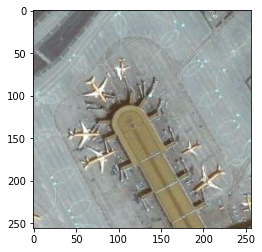

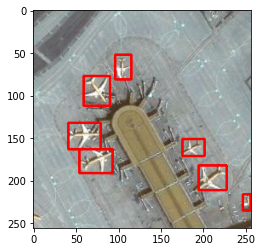

In [6]:
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

### We need cv2 to perform selective search on the images. To use selective search we need to download opencv-contrib-python. To download that just run pip install opencv-contrib-python in the terminal and install it from pypi.


In [7]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

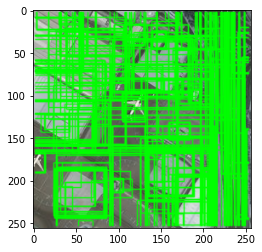

In [8]:
im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [9]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

##### The below code is pre-processing and creating the data-set to pass to the model. As in this case we can have 2 classes. These classes are that whether the proposed region can be a foreground (i.e. Airplane) or a background. So we will set the label of foreground (i.e. Airplane) as 1 and the label of background as 0. 

The following steps are being performed in the below code block.

1. Loop over the image folder and set each image one by one as the base for selective search using code ss.setBaseImage(image)
2. Initialising fast selective search and getting proposed regions using using code ss.switchToSelectiveSearchFast() and ssresults = ss.process()
3. Iterating over all the first 2000 results passed by selective search and calculating IOU of the proposed region and annotated region using the get_iou() function created below.
4. Now as one image can many negative sample (i.e. background) and just some positive sample (i.e. airplane) so we need to make sure that we have good proportion of both positive and negative sample to train our model. Therefore we have set that we will collect maximum of 30 negative sample (i.e. background) and positive sample (i.e. airplane) from one image.

After running the below code snippet our training data will be ready. List train_images=[] will contain all the images and train_labels=[] will contain all the labels marking airplane images as 1 and non airplane images (i.e. background images) as 0.

In [30]:
train_images=[]
train_labels=[]

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [11]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
#             print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]

            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
                
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        # print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

After completing the process of creating the dataset we will convert the array to numpy array so that we can traverse it easily and pass the datatset to the model in an efficient way.

In [12]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

X_new.shape

(30229, 224, 224, 3)

In [18]:
np.save('/content/drive/MyDrive/RCNN/Images.np',X_new)
np.save('/content/drive/MyDrive/RCNN/label.np',y_new)

In [8]:
X_new = np.load('/content/drive/MyDrive/RCNN/Images.np.npy')
y_new = np.load('/content/drive/MyDrive/RCNN/label.np.npy')

In [9]:
X_new = X_new.astype('uint8')

In [10]:
from keras.layers import Dense,Input
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras import layers
from keras import optimizers,regularizers,Input,callbacks

Now we will do transfer learning on the imagenet weight. We will import VGG16 model and also put the imagenet weight in the model.

In [ ]:
inputs = Input(shape=(224, 224, 3))
x = layers.experimental.preprocessing.RandomFlip(mode="horizontal",seed=0)(inputs)
x = layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.15, 0.15),
    width_factor=(-0.15, 0.15))(x)
x = layers.experimental.preprocessing.RandomRotation(factor=(-0.2, 0.3))(x)
x = layers.experimental.preprocessing.RandomZoom(height_factor=(-0.15, 0.15),
    width_factor=(-0.15, 0.15))(x)
x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)

vggmodel = VGG16(weights='imagenet', include_top=True, input_tensor=x)

for layer in (vggmodel.layers)[:15]:
    print(layer)
    layer.trainable = False

X= vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)

model_final = Model(inputs = inputs, outputs = predictions)
model_final.summary()

In this part in the loop we are freezing the first 15 layers of the model. After that we are taking out the second last layer of the model and then adding a 2 unit softmax dense layer as we have just 2 classes to predict i.e. foreground or background. After that we are compiling the model using Adam optimizer with learning rate of 0.001. We are using categorical_crossentropy as loss since the output of the model is categorical.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

After creating the model now we need to split the dataset into train and test set. Before that we need to one-hot encode the label. For that we are using MyLabelBinarizer() and encoding the dataset. Then we are splitting the dataset using train_test_split from sklearn. We are keeping 10% of the dataset as test set and 90% as training set.

In [13]:
X_new, X_test , Y, y_test = train_test_split(X_new,Y,test_size=0.10)
print(X_new.shape,X_test.shape,Y.shape,y_test.shape)

(27206, 224, 224, 3) (3023, 224, 224, 3) (27206, 2) (3023, 2)


In [26]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

my_callbacks = [ModelCheckpoint(filepath='/content/drive/My Drive/RCNN/new_model_weights.hdf5', monitor='val_loss',
                              verbose=1,save_best_only=True,save_weight=True),   
                EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')]

Now we start the training of the model using fit_generator.


In [ ]:
from keras.optimizers import Adam
opt = Adam(lr=0.00001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

hist = model_final.fit(X_new, Y, batch_size= 300, 
                                 epochs= 1000, validation_data= (X_test,y_test ), 
                                 callbacks=my_callbacks)

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

Now once we have created the model. We need to do prediction on that model. 

For that we need to follow the steps mentioned below :

1. pass the image from selective search.
2. pass all the result of the selective search to the model as input using model_final.predict(img).
3. If the output of the model says the region to be a foreground image (i.e. airplane image) and if the confidence is above the defined threshold then create bounding box on the original image on the coordinate of the proposed region.


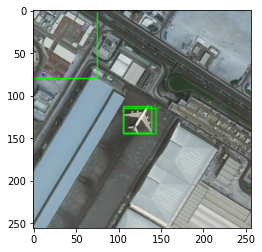

In [36]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.70:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)
        break

As you can see above we created box on the proposed region in which the accuracy of the model was above 0.95. In this way we can do localisation on an image and perform object detection using R-CNN. This is how we implement an R-CNN architecture from scratch using keras.
